# Week 10

## Agenda:

1.  Neural networks with hidden layers

#### Packages we will require this week

In [1]:
packages <- c(
    # Old packages
    "ISLR2",
    "dplyr",
    "tidyr",
    "readr",
    "purrr",
    "glmnet",
    "caret",
    "repr",
    "tidyverse",
    "torch",
    "torchvision",
    "torchdatasets",
    "mlbench",
    # NEW
    "nnet",
    "rpart",
    "e1071"
)

# renv::install(packages)
sapply(packages, require, character.only=TRUE)

Loading required package: ISLR2

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: tidyr

Loading required package: readr

Loading required package: purrr

Loading required package: glmnet

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-4

Loading required package: caret

Loading required package: ggplot2

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Loading required package: repr

Loading required package: tidyverse

-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.2.1     v forcats 0.5.2
v stringr 1.4.1     
-- Conflicts -------------

ISLR2         dplyr         tidyr         readr         purrr 
         TRUE          TRUE          TRUE          TRUE          TRUE 
       glmnet         caret          repr     tidyverse         torch 
         TRUE          TRUE          TRUE          TRUE          TRUE 
  torchvision torchdatasets       mlbench          nnet         rpart 
        FALSE         FALSE          TRUE          TRUE          TRUE 
        e1071 
         TRUE

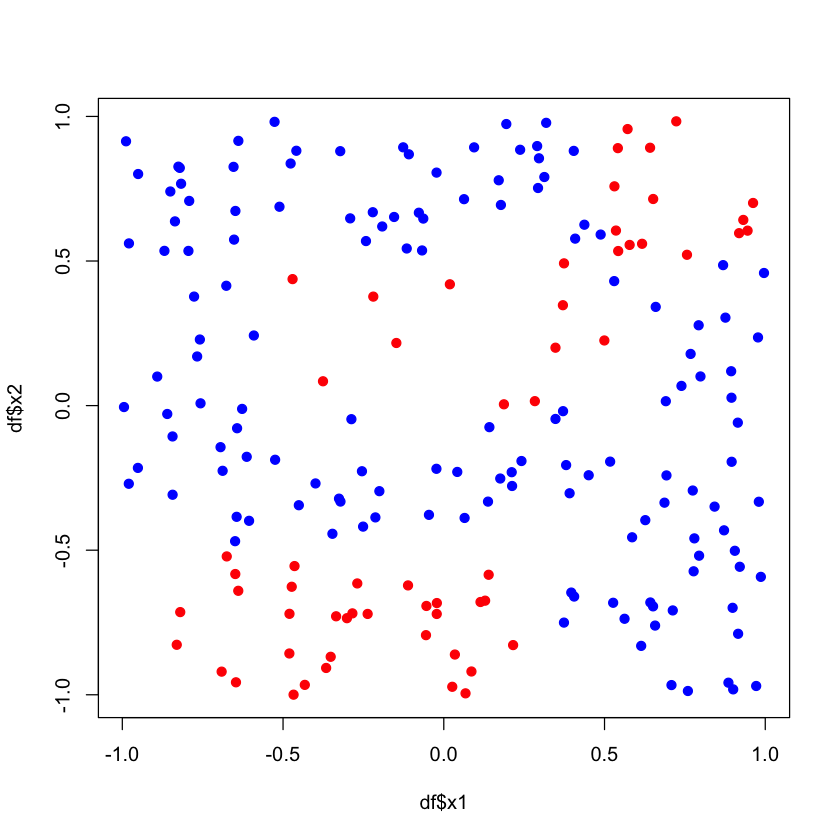

In [37]:
ex <- \(x) ifelse(
    # sign(x[1] * x[2]) + 0.01 * rnorm(1) <= 0,
    (x[1] < 0.5 && x[1] > -0.5 && x[2] < 0.5 && x[2] > 0) || 
    (x[1] > 0.5 && x[2] > 0.5 ) || 
    (x[1] < 0.25 && x[2] < -0.5), 
    1, 0
)


n <- 200
X <- t(replicate(n, 2 * runif(2) - 1))
y <- apply(X, 1, ex) %>% as.factor()
col <- ifelse(y == 0, "blue", "red")
df <- data.frame(y = y, x1 = X[, 1], x2 = X[, 2])
plot(df$x1, df$x2, col = col, pch = 19)


In [38]:
Xnew <- cbind(
    rep(seq(-1.1, 1.1, length.out=50), 50),
    rep(seq(-1.1, 1.1, length.out=50), each = 50)
)

df_new = data.frame(x1=Xnew[, 1], x2=Xnew[, 2])

plt <- function(f, x){
    plot(x[, 1], x[, 2], col=ifelse(f(x) < 0.5, "blue", "red"), pch=22)
    points(df$x1, df$x2, col= ifelse(y == "0", "blue", "red"), pch = 19)
}

overview <- function(f){
    predict <- ifelse(f(df[,-1]) < 0.5, 0, 1)
    actual <- df[,1]
    table(predict, actual)

}


       actual
predict   0   1
      0 141  59

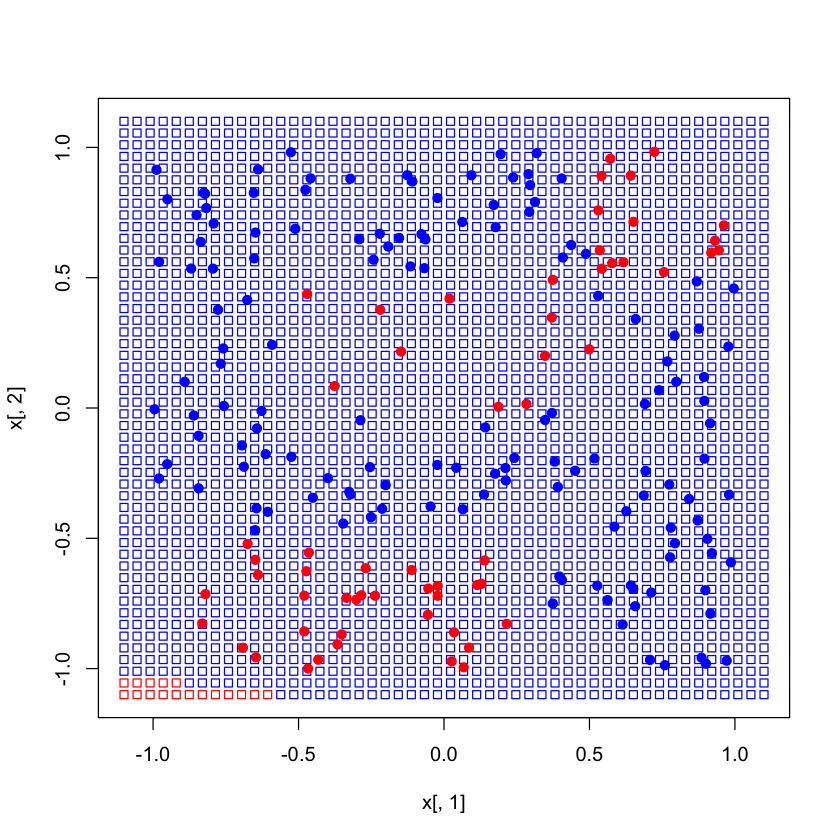

In [39]:
f_logit = \(x) glm(y ~ x1 + x2, df, family = binomial()) %>% predict(., x, type = "response")

plt(f_logit, df_new)
overview(f_logit)


       actual
predict   0   1
      0 141  13
      1   0  46

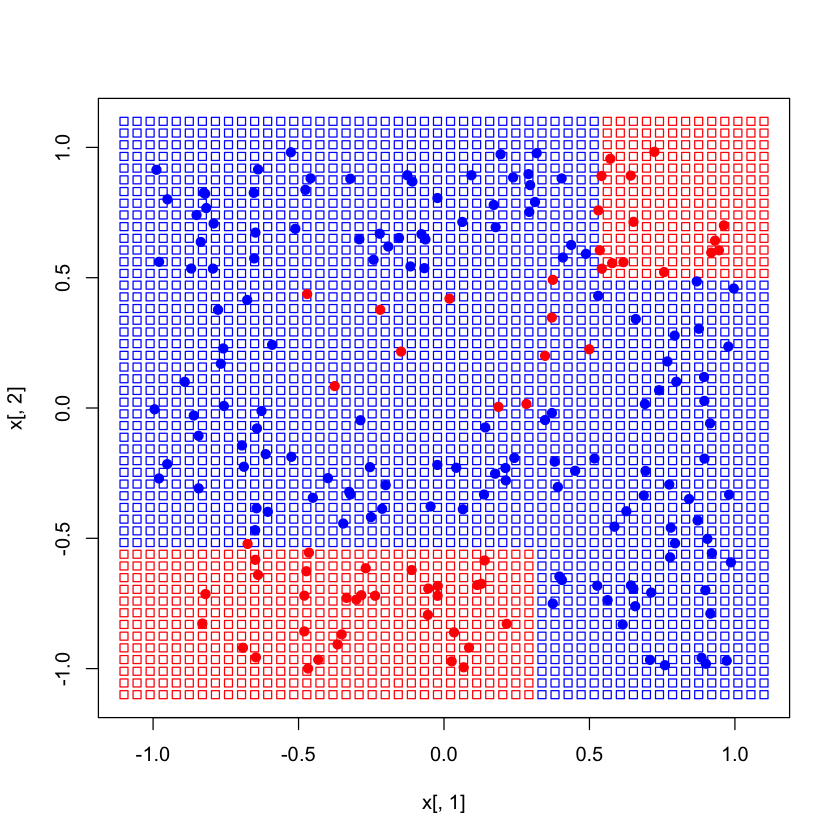

In [40]:
f_dtree = \(x) 
    rpart(y ~ x1 + x2, df, method="class") %>% 
    predict(., x, type="class") %>% 
    as.numeric(.) - 1

plt(f_dtree, df_new)
overview(f_dtree)

       actual
predict   0   1
      0 136  13
      1   5  46

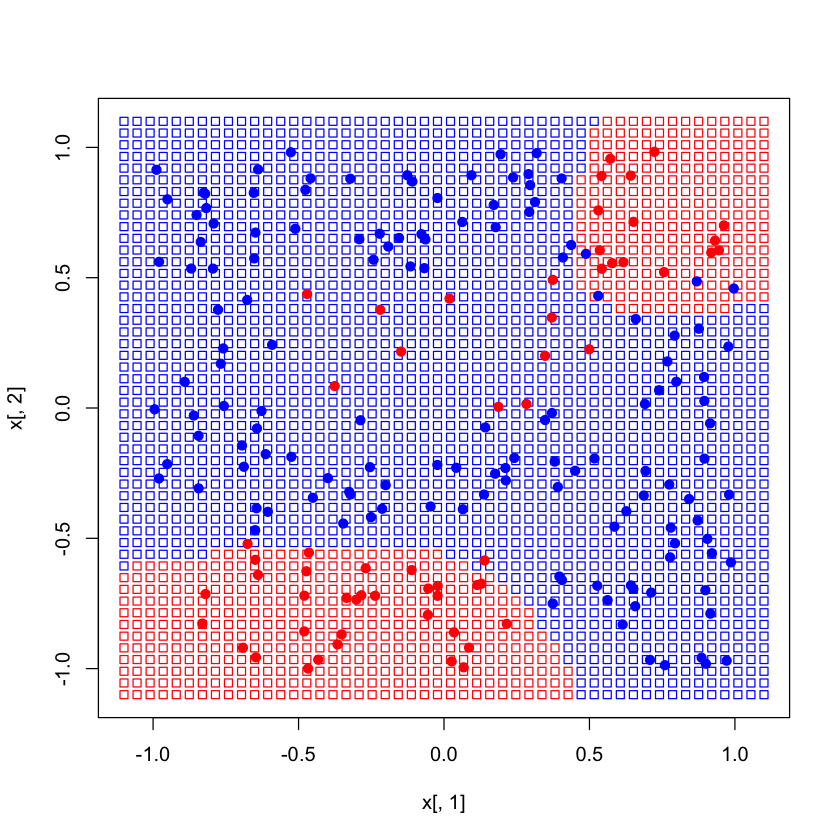

In [41]:
f_svm = \(x) 
    svm(y ~ x1 + x2, df, kernel = "radial") %>%
    predict(., x) %>%
    as.numeric(.) - 1

plt(f_svm, df_new)
overview(f_svm)

In [42]:
overview(f_logit)
overview(f_dtree)
overview(f_svm)

       actual
predict   0   1
      0 141  59

       actual
predict   0   1
      0 141  13
      1   0  46

       actual
predict   0   1
      0 136  13
      1   5  46

# Neural Network with 1 hidden layer

In [44]:
p <- 2
q <- 20 

hh1 <- nn_module(
    initialize = function(){
        self$f <- nn_linear(p, q)
        self$g <- nn_linear(q, 1)
        self$a <- nn_relu()
        self$s <- nn_sigmoid()
    },
    forward = function(x) {
        x %>% 
        self$f() %>%
        self$a() %>%
        self$g() %>%
        self$s()
    }
)

p <- 2
q1 <- 100
q2 <- 20
hh2_module <- nn_module(
    initialize = function(){
        self$f <- nn_linear(p, q1)
        self$g <- nn_linear(q1, q2)
        self$h <- nn_linear(q2, 1)
        self$a <- nn_relu()
        self$s <- nn_sigmoid()
    },
    forward = function(x) {
        x %>% 
        self$f() %>%
        self$a() %>%
        self$g() %>%
        self$a() %>%
        self$h() %>%
        self$s() 
    }
)

In [45]:
X_tensor <- torch_tensor(df[, -1] %>% as.matrix(), dtype=torch_float())
y_tensor <- torch_tensor(cbind(df[, 1] %>% as.numeric() - 1), dtype=torch_float())

In [46]:
Loss <- function(x, y, model){
  nn_bce_loss()(model(x), y)
}

In [48]:
F <- hh2_module()
Loss(X_tensor, y_tensor, F)

torch_tensor
0.698374
[ CPUFloatType{} ][ grad_fn = <BinaryCrossEntropyBackward0> ]

In [49]:
optimizer <- optim_adam(F$parameters, lr=0.05)
epochs <- 1000

for(i in 1:epochs){
    loss <- Loss(X_tensor, y_tensor, F)
    
    optimizer$zero_grad()
    loss$backward()
    optimizer$step()
    
    if (i < 10 || i %% 100 == 0) {
        cat(sprintf("Epoch: %d, Loss: %.4f\n", i, loss$item()))
    }
}

Epoch: 1, Loss: 0.6984
Epoch: 2, Loss: 0.6026
Epoch: 3, Loss: 0.5791
Epoch: 4, Loss: 0.5456
Epoch: 5, Loss: 0.5215
Epoch: 6, Loss: 0.4920
Epoch: 7, Loss: 0.4668
Epoch: 8, Loss: 0.4361
Epoch: 9, Loss: 0.4019
Epoch: 100, Loss: 0.0179
Epoch: 200, Loss: 0.0026
Epoch: 300, Loss: 0.0009
Epoch: 400, Loss: 0.0004
Epoch: 500, Loss: 0.0003
Epoch: 600, Loss: 0.0002
Epoch: 700, Loss: 0.0001
Epoch: 800, Loss: 0.0001
Epoch: 900, Loss: 0.0001
Epoch: 1000, Loss: 0.0001


       actual
predict   0   1
      0 141   0
      1   0  59

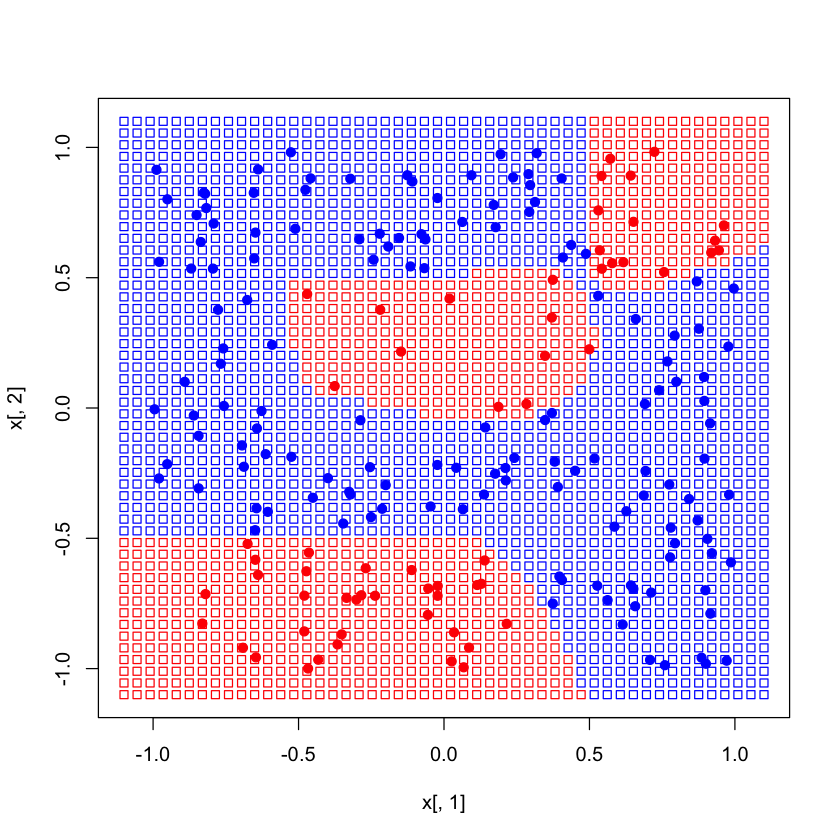

In [51]:
f_nn = \(x) as_array(F(torch_tensor(x %>% as.matrix(), dtype = torch_float())))
plt(f_nn, df_new)
overview(f_nn)

------------------------------------------------------------------------

Let’s wrap these methods in a function:

``` r
classifier <- 
function(train, type="nn", ...){

    if(type == "logistic"){
        # ... code
    }
    
    else if(type == "rpart"){
        # ... code
    }
        
    else if(type == "svm"){
        # ... code
    }
        
    else if(type == "nn"){
        # ... code
    }
    
    # ...return a function
}
```

In [ ]:
classifier <- 
function(train, type="nn", ...){
    
    if(type == "logistic"){
        f = \(x) glm(y ~ x1 + x2, train, family=binomial()) %>% 
                 predict(., x, type="response")
    }
    
    else if(type == "rpart"){
        f = \(x) 
            rpart(y ~ x1 + x2, df, method="class") %>% 
            predict(., x, type="class") %>% 
            as.numeric(.) - 1
    }
        
    else if(type == "svm"){
        f = \(x)
            svm(y ~ x1 + x2, df, kernel="radial") %>% 
            predict(., x) %>% 
            as.numeric(.) - 1
    } 
        
    else if(type == "nn"){
        X_tensor <- torch_tensor(train[, -1] %>% as.matrix(), dtype=torch_float())
        y_tensor <- torch_tensor(cbind(train$y %>% as.numeric() - 1), dtype=torch_float())
        F <- hh2_module()
        optimizer <- optim_adam(F$parameters, lr=0.05)
        epochs <- 1000

        for(i in 1:epochs){
            loss <- nn_bce_loss()(F(X_tensor), y_tensor)
            optimizer$zero_grad()
            loss$backward()
            optimizer$step()
        }
        f = \(x) as_array(F( torch_tensor(x %>% as.matrix(), dtype=torch_float()) ))
    }
    
    return(f)
}

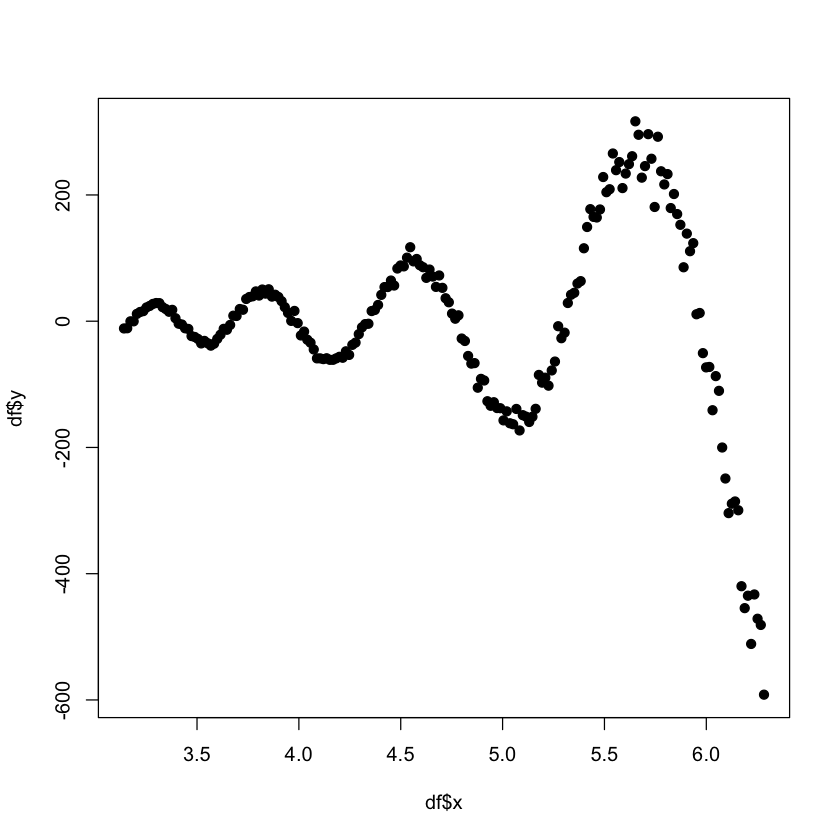

In [52]:
generate_data <- function(n, noise = 0.1) {
x <- seq( 1 *pi, 2 *pi, length.out = n)
y <- exp(x) *(sin( 150 /x) +rnorm(n, 0 , noise))
data.frame(x = x, y = y)
}
df <- generate_data( 200 , noise = 0.1)
plot(df$x, df$y, pch= 19 )

In [56]:
x_new<- seq(0.9 *pi, 2.1*pi, length.out = 1000 )
df_new <- data.frame(x = x_new)

plt_reg<- function(f, x){
    ynew <- f(x)
    ylim <- range(c(ynew, df$y))
    ylim[ 1 ] <- max(c(- 800 , ylim[ 1 ]))
    ylim[ 2 ] <- min(c( 250 , ylim[ 2 ]))
    xlim <-range(x)
    plot(df$x, df$y, pch = 22 , col ='red',xlim=xlim,ylim = ylim)
    points(x[, 1 ], ynew, pch= 22 ,type='l')
}


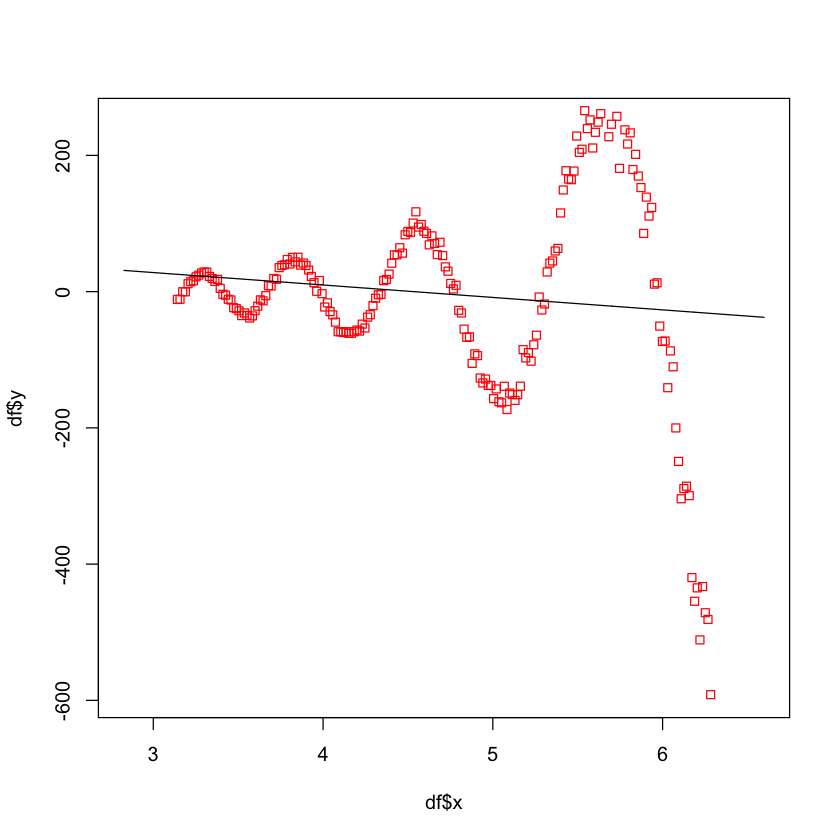

In [57]:
# LR
f_lm = \(x) lm(y ~ x, df,) %>% predict(., x) 
plt_reg(f_lm, df_new)

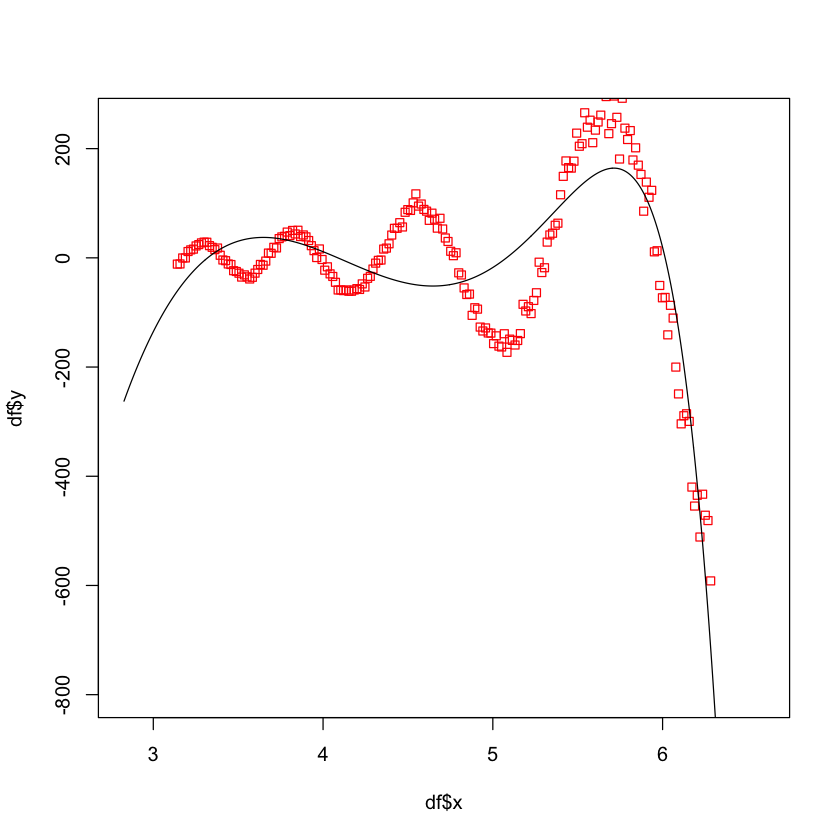

In [60]:
f_polynomial = \(x) lm(y ~ x + I(x^2) + I(x^3) + I(x^18)  , df,) %>% predict(., x) 
plt_reg(f_polynomial, df_new)

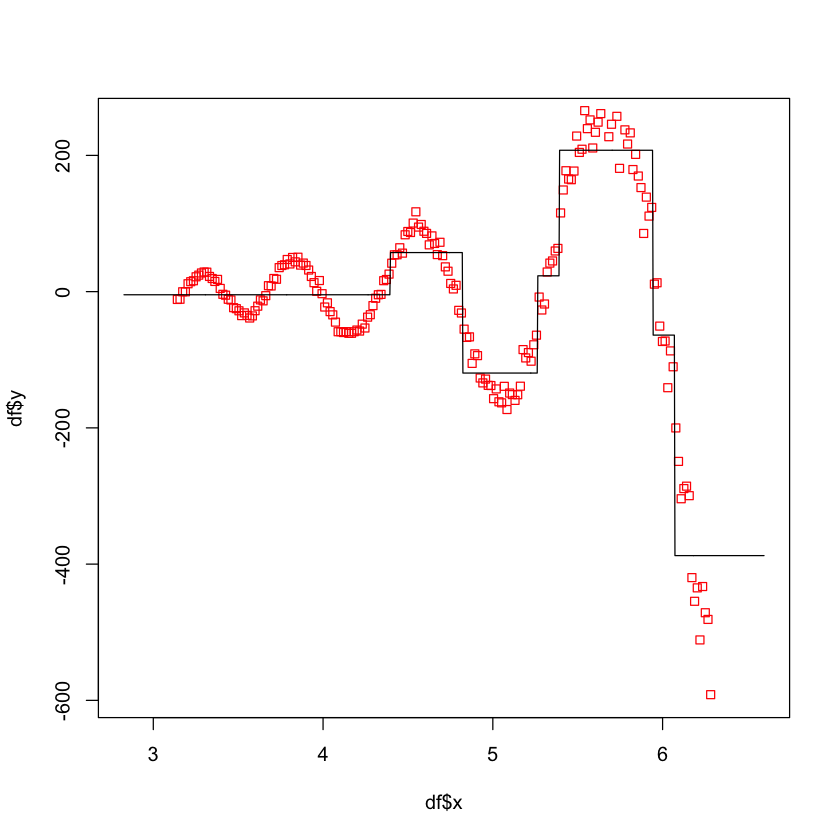

In [61]:
f_dtree = \(x) rpart(y ~ x, df) %>% predict(., x) 
plt_reg(f_dtree, df_new)

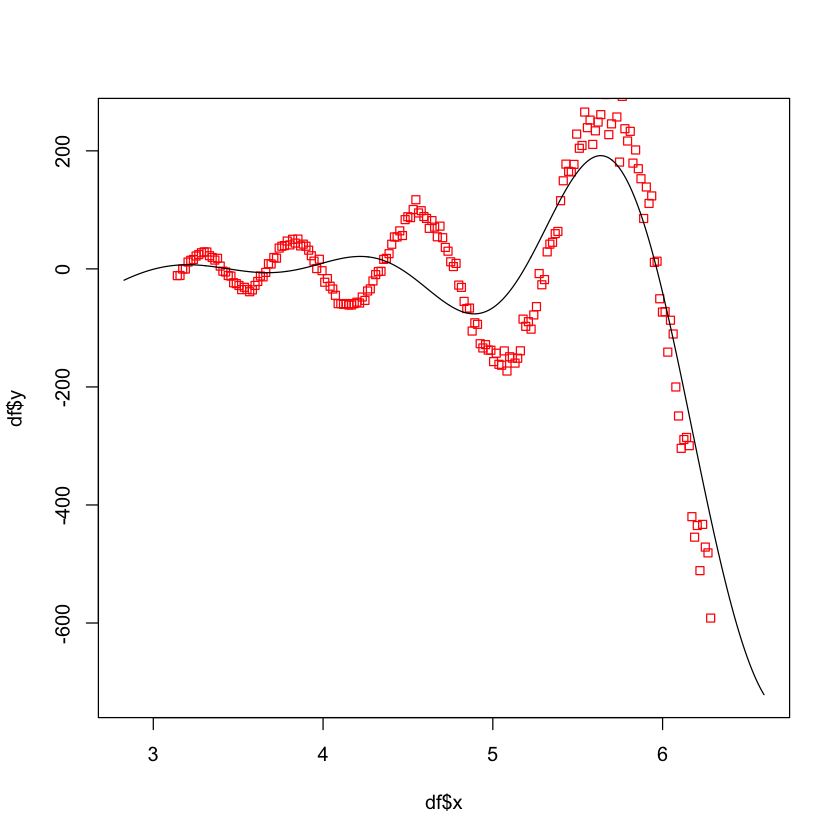

In [62]:
f_svm = \(x) svm(y ~ x, df, kernel = "radial") %>% predict(., x) 
plt_reg(f_svm, df_new)

------------------------------------------------------------------------

# Regression with Neural Networks

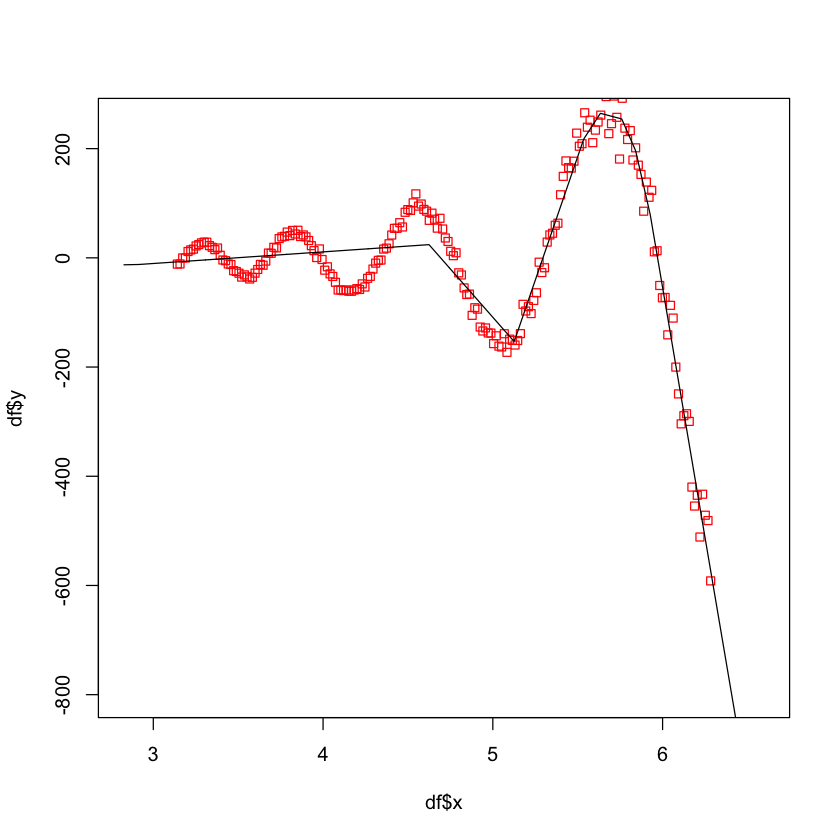

In [63]:
reg_module <- nn_module(
initialize = function(){
self$f <- nn_linear(1,20)
self$g <- nn_linear(20,100)
self$h <- nn_linear(100,1)
self$a <- nn_relu()
# note there is no sigmoid at the end.
# try using sigmoid as an activation function for a smoother model. changing the learn
},
forward = function(x){
x %>%
self$f() %>%
self$a() %>%
self$g() %>%
self$a() %>%
self$h()
}
)

f_nn <- function(x){
    F <- reg_module()
    X_tensor <- torch_tensor(df$x%>%as.matrix(),dtype=torch_float())
    y_tensor<-torch_tensor(cbind(df$y),dtype=torch_float())
    optimizer<-optim_adam(F$parameters,lr=0.006)
    epochs<-2000
    for(i in 1:epochs){
        loss<-nn_mse_loss()(F(X_tensor),y_tensor)
        optimizer$zero_grad()
        loss$backward()
        optimizer$step()
    }
return(as_array(F(torch_tensor(x%>%as.matrix(),dtype=torch_float()))))
}
plt_reg(f_nn, df_new)

------------------------------------------------------------------------

### Linear regression

------------------------------------------------------------------------

### Polynomial regression

------------------------------------------------------------------------

### Regression Tree

------------------------------------------------------------------------

### SVM

------------------------------------------------------------------------

### Neural Network